# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [90]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import pickle
from stable_baselines3.common.monitor import Monitor
import networkx as nx

from task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from utils.config_utils import parse_task_config, parse_model_config, load_config
from utils.pytorch_utils import DEVICE
from model.agents.value_iteration import ValueIterationAgent

from utils.pytorch_utils import (
    train_epochs,
    convert_float_to_8bit,
    make_tensor,
    convert_8bit_array_to_float_tensor,
    convert_8bit_to_float,
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.2.1
device = mps


In [92]:
CONFIG_PATH = "configs"
TASK_CONFIG_FILE = "env_config.yml"
VAE_CONFIG_FILE = "vae_config.yml"
AGENT_CONFIG_FILE = "agent_config.yml"

TASK_NAME = "thread_the_needle"
MODEL_NAME = "cnn_vae"

# Create log dir
LOG_DIR = "tmp/"
os.makedirs(LOG_DIR, exist_ok=True)

TASK_CLASS = ThreadTheNeedleEnv
AgentClass = ValueIterationAgent

## Load Configs
task_config_file = os.path.join(CONFIG_PATH, TASK_CONFIG_FILE)
vae_config_file = os.path.join(CONFIG_PATH, VAE_CONFIG_FILE)
agent_config_file = os.path.join(CONFIG_PATH, AGENT_CONFIG_FILE)

env_kwargs = parse_task_config(TASK_NAME, task_config_file)
vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)

# create the task and get the optimal policy
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))
pi, _ = task.get_optimal_policy()

SAVE_FILE_NAME = f"simulations/thread_the_needle_viagent_offline.csv"

  0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
# create the task and get the optimal policy
task = TASK_CLASS.create_env(**env_kwargs)
task = CnnWrapper(task)

# create the monitor
task = Monitor(task, LOG_DIR)

pi, _ = task.get_optimal_policy()
# training_kwargs["optimal_policy"] = pi

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_optimal_policy to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_optimal_policy` for environment variables or `env.get_wrapper_attr('get_optimal_policy')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [94]:
# load the rollouts 
rollouts_file = 'simulations/oracle_rollouts.pkl'

with open(rollouts_file, 'rb') as f:
    rollouts = pickle.load(f)



In [95]:
### Model + Training Parameters

vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)


def make_model():
    agent = AgentClass.make_from_configs(task, agent_config, vae_config, env_kwargs)
    return agent


agent = make_model()
total_params = sum(p.numel() for p in agent.state_inference_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1970545


In [96]:
agent = make_model()
agent.update_from_batch(rollouts, progress_bar=True)


Vae Epochs: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


In [97]:
Laplacian, state_key = agent.get_graph_laplacian()
Laplacian

array([[ 9.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  9.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  6., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

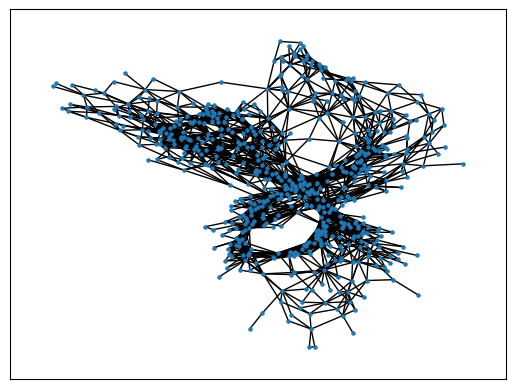

In [98]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)

pos = nx.spring_layout(G, k=0.1)

nx.draw_networkx(G, with_labels=False, node_size=5)

In [99]:
agent.get_state_values()
node_values = {state_key[i]: v for i, v in agent.get_state_values().items()}

# normalize the node_vlaues
v_max = max([v for v in node_values.values()])
v_min = min([v for v in node_values.values()])
node_values = {k: (v - v_min) / (v_max - v_min) for k, v in node_values.items()}

print(f"Number of nodes: {len(node_values)}")

Number of nodes: 575


In [100]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degree_sequence

[37,
 35,
 34,
 33,
 31,
 31,
 31,
 30,
 29,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,


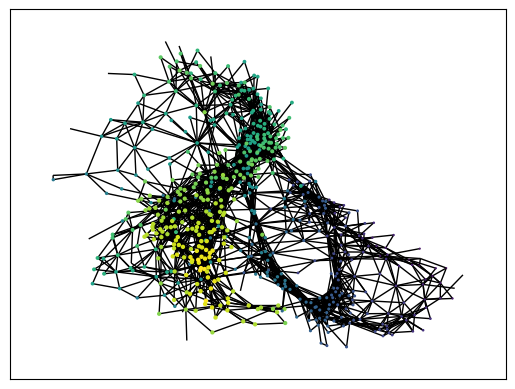

In [101]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
color = [node_values.get(i, 0) for i in G.nodes]
size = [node_values.get(i, 0) * 5 for i in G.nodes]
nx.draw_networkx(G, with_labels=False, node_size=size, node_color=color, cmap="viridis")



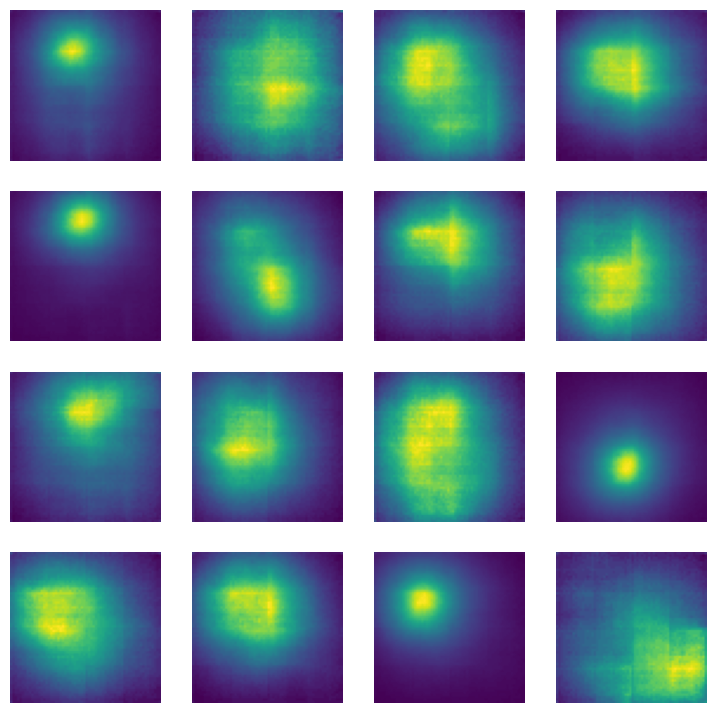

In [102]:
vae_model = agent.state_inference_model

import torch.nn.functional as F

# Sample generatively

z_layers = vae_config["vae_kwargs"]["z_layers"]
z_dim = vae_config["vae_kwargs"]["z_dim"]

N = 4


def sample_random_state():
    z = torch.randint(high=z_dim, size=tuple([z_layers]))
    return F.one_hot(z, num_classes=z_dim).to(DEVICE)


fig, axes = plt.subplots(N, N, figsize=(9, 9))

vae_model.eval()
for t in range(N**2):
    with torch.no_grad():
        z = sample_random_state()
    X_hat = vae_model.decode(z).detach().cpu()

    r, c = t // N, t % N
    plt.sca(axes[r][c])
    plt.imshow(convert_float_to_8bit(X_hat.squeeze()))
    plt.axis("off")

plt.show()

In [103]:

pmf = agent.get_policy_prob(agent.get_env(), n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True)
pmf

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.generate_observation to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.generate_observation` for environment variables or `env.get_wrapper_attr('generate_observation')` that will search the reminding wrappers.
  logger.warn(


array([[2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01],
       [7.68614661e-42, 3.72732220e-09, 7.68614661e-42, 9.99999996e-01],
       [7.68614661e-42, 3.72732220e-09, 7.68614661e-42, 9.99999996e-01],
       ...,
       [5.80340833e-88, 4.19977092e-28, 1.00000000e+00, 3.79590004e-34],
       [5.80340833e-88, 4.19977092e-28, 1.00000000e+00, 3.79590004e-34],
       [2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01]])

In [104]:
sorted(list(agent.value_function.values()))

[7288.770138080654,
 7307.875630086408,
 7352.850185194306,
 7370.795101379904,
 7381.797900355493,
 7445.19060725672,
 7450.702529486305,
 7463.851494895274,
 7464.4150232496495,
 7483.656534055034,
 7487.482145957124,
 7503.946146259243,
 7518.806156621391,
 7519.746804595609,
 7519.746804595609,
 7541.706826022589,
 7541.706826022589,
 7559.354369009728,
 7559.801296388182,
 7563.21862345618,
 7579.0532301313515,
 7595.8091877393235,
 7617.9910275647035,
 7623.685598896922,
 7632.85280699162,
 7645.972886048086,
 7655.714668076712,
 7669.852658355296,
 7679.362798289372,
 7679.362798289372,
 7682.220411750094,
 7684.968034956149,
 7687.419739523679,
 7689.583096031595,
 7693.01680660441,
 7693.01680660441,
 7693.01680660441,
 7693.01680660441,
 7700.797868850147,
 7710.057675007717,
 7739.703180078828,
 7748.067981296662,
 7757.037464195752,
 7765.175788677278,
 7766.3119448120515,
 7766.3119448120515,
 7769.311180353191,
 7770.829391787014,
 7783.370823106631,
 7807.603438077784,
 

In [105]:
sorted(list(agent.value_function.values()))[::-1]

[9999.568287525888,
 9999.568287525888,
 9999.568287525888,
 9999.568287525888,
 9999.568287525888,
 9924.25720771812,
 9923.16123976285,
 9917.336229648692,
 9916.76167489195,
 9915.395110837291,
 9911.508985668448,
 9911.230546201938,
 9904.98883526954,
 9901.234484959396,
 9900.895965759806,
 9896.332772727676,
 9895.416952158332,
 9888.45945189403,
 9883.030444857564,
 9880.40676543278,
 9880.40676543278,
 9864.142862954575,
 9853.50991049558,
 9843.960872224081,
 9836.273287818243,
 9834.513913601737,
 9833.490207352193,
 9831.098893856746,
 9824.910334576452,
 9824.44761560958,
 9823.193259333522,
 9821.072879603675,
 9819.568970789998,
 9819.475795372258,
 9818.05857757025,
 9818.05857757025,
 9817.489764034312,
 9816.136866853494,
 9816.136866853494,
 9814.1035188878,
 9812.013948201058,
 9810.45019958747,
 9806.422423125234,
 9805.151181633442,
 9800.321241194188,
 9786.686767090976,
 9782.86794777403,
 9779.980670566294,
 9779.980670566294,
 9765.095515808025,
 9763.371511172

Text(0.5, 0.98, 'Value Iteration Agent Learned Policy')

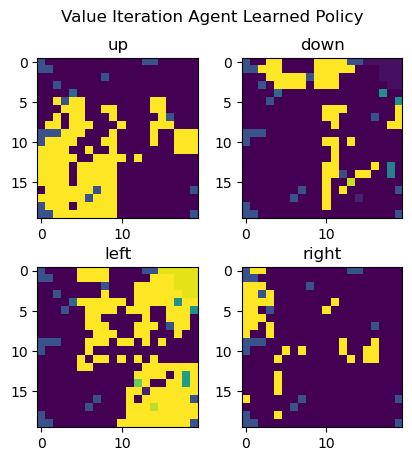

In [106]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

In [107]:
np.sum(pi * pmf, axis=1).mean()

0.8587460483405696

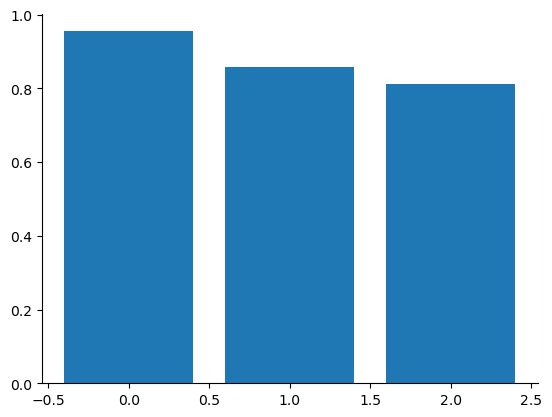

In [108]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1792: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i, j] = metric(X[i], Y[j], **kwds)


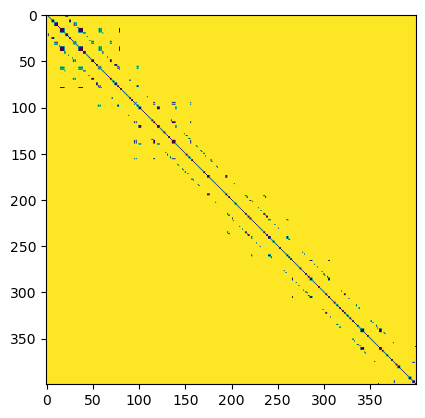

In [109]:
from utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.display_gridworld to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.display_gridworld` for environment variables or `env.get_wrapper_attr('display_gridworld')` that will search the reminding wrappers.
  logger.warn(


<Axes: title={'center': 'Thread-the-needle states'}>

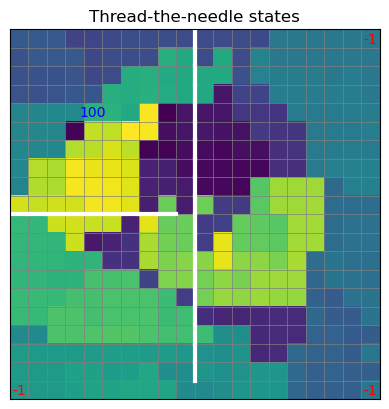

In [110]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

In [111]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

Distance between neighboring states sepearted by a wall     0.14285714285714285
Distance between neighboring states NOT sepearted by a wall 0.25


/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.transition_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.transition_model` for environment variables or `env.get_wrapper_attr('transition_model')` that will search the reminding wrappers.
  logger.warn(
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.n_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.n_states` for environment variables or `env.get_wrapper_attr('n_states')` that will search the reminding wrappers.
  logger.warn(


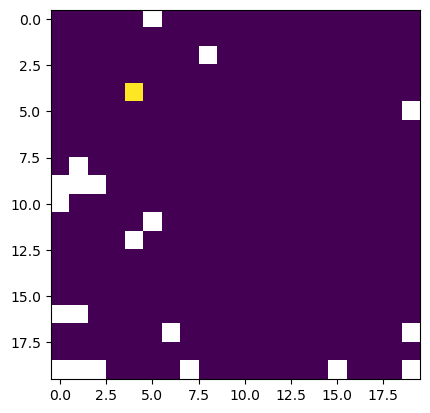

In [112]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_model` for environment variables or `env.get_wrapper_attr('observation_model')` that will search the reminding wrappers.
  logger.warn(


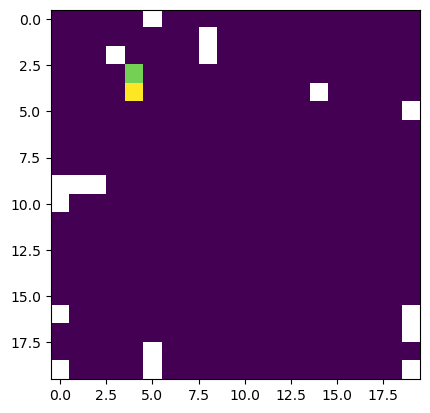

In [113]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.display_gridworld to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.display_gridworld` for environment variables or `env.get_wrapper_attr('display_gridworld')` that will search the reminding wrappers.
  logger.warn(


Text(0.5, 1.0, 'Learned Value function')

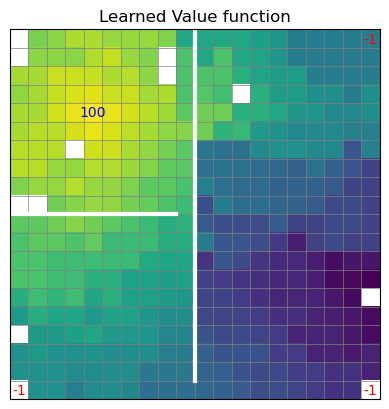

In [114]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    )[:, None, ...].to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.imshow(v)
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

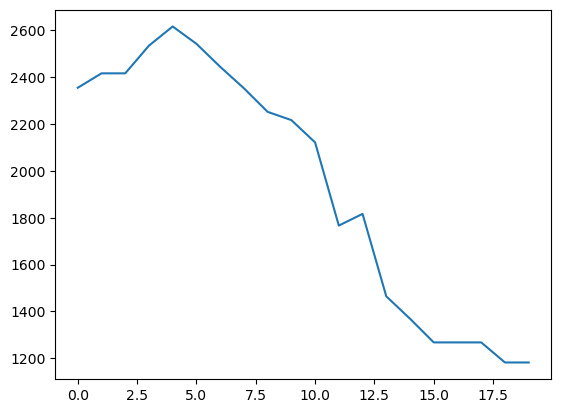

In [115]:
plt.plot(v[5] - np.nanmin(v))

In [116]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
from tqdm import trange


## Repeat with iterations
n_models = 8
# n_models=4


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=False)
    #     agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        vae_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

In [ ]:
# Plot the average value function (n)

# normalize the value function between zero and one within each iteration
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(grouped_data):
    v = grouped_data["State-Values"].values.reshape(-1, 1)
    v = MinMaxScaler().fit_transform(grouped_data["State-Values"].values.reshape(-1, 1))
    grouped_data["State-Values"] = v
    return grouped_data.drop("Iteration", axis=1)


normed_vf = value_functions.groupby("Iteration", group_keys=True).apply(min_max_scale)

# average and plot
plt.imshow(x.groupby("States").mean().values.reshape(20, 20))
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
# plot 1d Value function through the goal
normed_vf["Row"] = normed_vf["States"] // 20
normed_vf["Column"] = normed_vf["States"] % 20

sns.relplot(
    data=normed_vf[normed_vf["Row"] == 4], x="Column", y="State-Values", kind="line"
)
sns.relplot(
    data=normed_vf[(normed_vf["Column"] >= 9) & (normed_vf["Column"] <= 10)],
    x="Row",
    y="State-Values",
    kind="line",
    hue="Column",
)

plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv('value_functions_vae.csv')

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Model"] = "Value Iteration"
scores.to_csv(SAVE_FILE_NAME)
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"
scores3 = pd.read_csv("sims_thread_the_needle_state_inf.csv")
scores3["Model"] = "Value Iteration + action based decoder"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

In [ ]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])